In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict silver ("Close") returns with *lagged* silver returns. 

In [2]:
# Futures contract on the silver price:

silver = pd.read_csv(
    Path("silver.csv"), index_col="Date",parse_dates=True
)
silver.head()

Close Volume    Open    High     Low
Date                                             
2014-12-15  16.563    N/A  16.563  16.563  16.563
2014-12-16  15.752  70815  16.205  16.665  15.540
2014-12-17  15.928  45134  15.755  16.060  15.615
2014-12-18  15.934  32694  15.755  16.230  15.740
2014-12-19  16.030  20764  15.875  16.110  15.830

In [3]:
# Trim the dataset to begin on December 15, 2014
silver = silver.loc["2014-12-15":, :]
silver.head()



Close Volume    Open    High     Low
Date                                             
2014-12-15  16.563    N/A  16.563  16.563  16.563
2014-12-16  15.752  70815  16.205  16.665  15.540
2014-12-17  15.928  45134  15.755  16.060  15.615
2014-12-18  15.934  32694  15.755  16.230  15.740
2014-12-19  16.030  20764  15.875  16.110  15.830

# Data Preparation

### Returns

In [4]:
# Create a series using "Close" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
silver['Return'] = silver.Close.pct_change() * 100
silver = silver.replace(-np.inf, np.nan).dropna()
silver.tail()

Close  Volume    Open   High     Low    Return
Date                                                       
2019-12-09  16.642   51185  16.600  16.73  16.565  0.976882
2019-12-10  16.596     188  16.555  16.61  16.555 -0.276409
2019-12-11  16.849   60730  16.915  16.93  16.910  1.524464
2019-12-12  16.949  111614  16.920  17.03  16.905  0.593507
2019-12-13  16.912      23  16.880  16.89  16.825 -0.218302

### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
silver['Lagged_Return'] = silver.Return.shift()
silver = silver.replace(-np.inf, np.nan).dropna()
silver.tail()

Close  Volume    Open   High     Low    Return  Lagged_Return
Date                                                                      
2019-12-09  16.642   51185  16.600  16.73  16.565  0.976882      -3.388241
2019-12-10  16.596     188  16.555  16.61  16.555 -0.276409       0.976882
2019-12-11  16.849   60730  16.915  16.93  16.910  1.524464      -0.276409
2019-12-12  16.949  111614  16.920  17.03  16.905  0.593507       1.524464
2019-12-13  16.912      23  16.880  16.89  16.825 -0.218302       0.593507

### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = silver[:'2018']
test = silver['2018':]


In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
X_test = test["Lagged_Return"].to_frame()
y_train = train["Return"]
y_test = test["Return"]

In [8]:
X_train.head()

Lagged_Return
Date                     
2014-12-17      -4.896456
2014-12-18       1.117318
2014-12-19       0.037670
2014-12-22       0.602485
2014-12-23      -2.133500

# Linear Regression Model

In [9]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [11]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Return"] = predictions
#Results.head()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022F22B7CA58>,
      dtype=object)

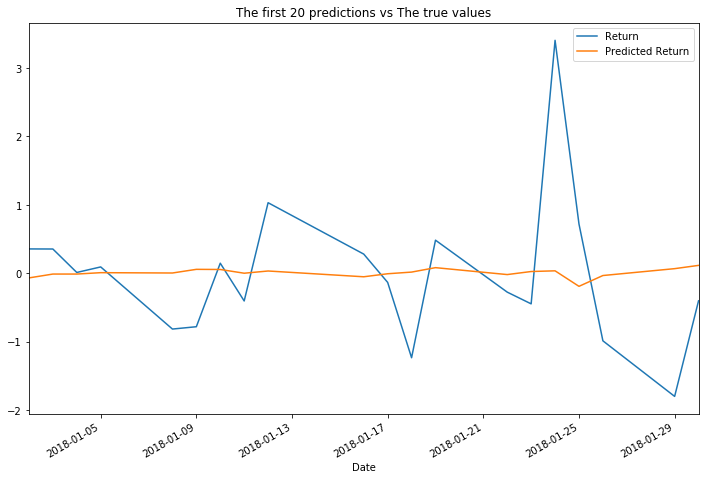

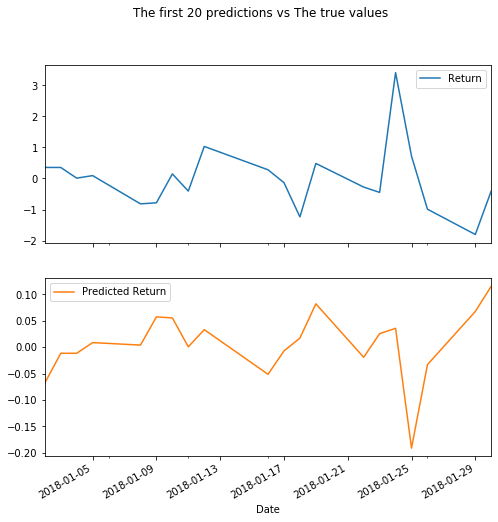

In [12]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(title='The first 20 predictions vs The true values', figsize=(12, 8))
Results[:20].plot(subplots=True, figsize=(8, 8), title='The first 20 predictions vs The true values')

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [13]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 1.2181553208025875


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [14]:
# Construct a dataframe using just the "y" training data:
in_sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(
    in_sample_results["Return"],
    in_sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 1.437424828816414


# Conclusions

YOUR CONCLUSIONS HERE!

### lower RMSE is the the sign of fitness of our model, that is why this model perform better with in-Sample data utilization! 